<a href="https://colab.research.google.com/github/MatMig42/DocumentClassifierWithAlexNet/blob/main/DocumentClassifierWithAlexNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Vorbedingungen

Der Tobacco-3482 Datensatz liegt in einem zip-Archiv auf einem Ordner auf einem Google Drive.<br>
Im Laufe der Codeausführung wird dieser zip-Ordner auf die Instanz dieses Notebooks kopiert.<br>
Der Datensatz kann beispielsweise von https://www.kaggle.com/patrickaudriaz/tobacco3482jpg heruntergeladen werden.<br>
Es wird angenommen, dass die Daten in folgender Struktur in dem ZIP-Archiv sortiert sind:<br>
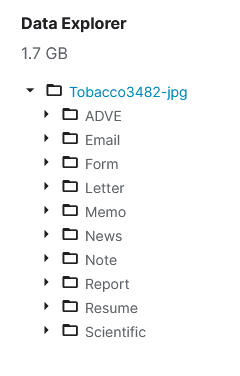
<br>
Bei einem ersten Durchlauf sollte das ganze Notebook einmal durchlaufen werden, um sicherzustellen, dass alle Variablen und Packages richtig initialisiert sind.

# Tobacco-3482 Datensatz vorbereiten

Erste Python-Pakete laden und Zugang zu Google Drive herstellen

In [1]:
import numpy as np
import pandas as pd
import os
from datetime import datetime
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


Den Tobacco-3482 Datensatz vom Google Drive auf die aktuelle Colabs Instanz kopieren und entpacken.<br>
Dies steigert die Performanz beim Laden der Bilder und damit die Geschwindigkeit beim Trainieren des Netzes.<br>
Der initiale Kopiervorgang kann wenige Minuten in Anspruch nehmen.<br>
<b>Die Variable *path_to_dataset* muss vermutlich angepasst werden.</b><br>
Diese Variable zeigt auf den Pfad zu dem Tobacco-3482 Datensatz

In [2]:
# Gegebenfalls anpassen
path_to_dataset = \
  '/content/drive/MyDrive/ML_Datasets/Tobacco3482-jpg.zip'

# Zip-Archiv nur kopieren, wenn es nicht bereits
# entpackt vorliegt.
# Sollte der Ordner 'Tobacco3482-jpg' korrumpiert sein,
# muss er gelöscht werden und dieser Code erneut
# ausgeführt werden
if not 'Tobacco3482-jpg' in os.listdir():
  print('Kopiere Daten. Die kann einige Minuten dauern...')
  # Ins Homeverzeichnis kopieren
  !cp '{path_to_dataset}' .
  print('Entpacke zip-archiv...')
  !unzip -q Tobacco3482-jpg.zip
  !rm Tobacco3482-jpg.zip
  print('Erledigt!')
else:
  print('Bilder werden nicht kopiert, da sie schon vorhanden sind')

Kopiere Daten. Die kann einige Minuten dauern...
Entpacke zip-archiv...
Erledigt!


Hier wird der Inhalt des Ordners mit den Trainingsdaten in einen Pandas Dataframe geladen, um später über diesen Dataframe auf die Biler zuzugreifen.<br>
Der Dataframe beinhaltet nach Ausführung dieses Abschnitts den Pfad zu allen 3482 Bilder mit dem jeweiligen Label.<br>
**Die Variable *tobacco_img_folder* muss angepasst werden, wenn das zip-Archiv nicht von Kaggle, sondern einer anderen Quelle heruntergeladen wurde.**<br>
Zur Erinnerung: Im Ordner *tobacco_img_folder* sollten 10 Unterordner liegen, die die Namen der 10 Klassen tragen und die Bilder der jeweiligen Klasse beinhalten.  

In [3]:
# In den Ordner mit den Bildern wechseln
# Diese Variable ggf. anpassen
tobacco_img_folder = '/content/Tobacco3482-jpg/'
os.chdir(tobacco_img_folder)

# Die Ordnernamen entsprechen den Labels
labels = os.listdir()
print(len(labels),'gefunde Labels:', labels)

num_found_images = 0
dataset_list = []

# Durch alle Ordner gehen und auflisten, wie die Bilder heißen
for root, dir, files in os.walk("."):
  # Leere Ordner überspringen
  if len(files) != 0:
    for file in files:
      # Nur Bilder beachten, den Rest (e.g. Thumbs.db) überspringen
      if file.split('.')[-1] != 'jpg':
        continue
      num_found_images += 1  
      label = root.split('/')[-1]
      path_to_img = tobacco_img_folder + '/' + label + '/' + file
      dataset_list.append([path_to_img, label])

# Sanity checks
if len(labels) != 10:
  print ('Fehler! Es wurden ' + str(len(labels)) + 
         ' Labels gefunden (Erwarte 10)')
if num_found_images == 3482:
  print('Alle Bilder gefunden!')
else:
  print('Fehler! Es wurden nicht alle Bilder gefunden!')
  print('Anzahl gefundene Bilder:', num_found_images)

# Die Bilderliste in einen pd.DataFrame umwandeln
dataset_df = pd.DataFrame(dataset_list, columns=['Path', 'Label'])
# Die Daten ein erstes Mal durchmischen
dataset_df = dataset_df.sample(frac=1).reset_index(drop=True)

10 gefunde Labels: ['Email', 'Form', 'News', 'Note', 'Memo', 'Report', 'Resume', 'Scientific', 'ADVE', 'Letter']
Alle Bilder gefunden!


Trainingsdaten partitionieren und in Trainings-, Validierungs- und Testdatensätze aufsplitten:<br>
In der Veröffentlichung von Afzal et al. wurden 100 Partitionen mit unterschiedlicher Größe der drei Datensätze erstellt.
<br>Diese 100 Partitionen werden durch eine Liste, die 3x100 Pandas Dataframes enthält, repräsentiert.<br>
Das Aufteilen in Trainingsdaten und Validierungsdaten in einem Verhältnis von 80:20 wird hier händisch vorgenommen.
<br>Eine mögliche andere Implementierung, wäre es diese Aufteilung dem Keras DataGenerator zu überlassen.<br>
**Achtung:** Die kleineren Trainingsdatensätze sind immer Untermengen von größeren Trainingsdatensätzen, da der *dataset_df* beim Aufteilen in die drei Datensätze nicht jedesmal neu durchmischt wird.

In [4]:
# Zuerst einen Dataframe mit allen Bildern erstellen, damit der entsprechende
# Ordner nur einmal durchsucht werden muss.
partitions = []
partitions_size_dict = {}

# Die Anzahl der Partition ist hier auf 30 gestellt, da
# 100 Paritionen zu einem OOM Fehler führen. Siehe Bericht.
for i in range(30):
  # Bestimme zufällige Größe des Traindatensatzes
  # Mindestens 20, maximal 100 Bilder
  # Aufteilung in Validierungs- und Trainingsdatensatz erfolgt später
  num_train_img_per_class = int(np.rint(np.random.random_sample() * 80)) + 20
  # Initialisiere leere Dataframes
  train_df = pd.DataFrame(columns=['Path', 'Label'])
  val_df = pd.DataFrame(columns=['Path', 'Label'])
  test_df = pd.DataFrame(columns=['Path', 'Label'])

  # Füge die Bilder für jedes Label den entsprechenden
  # Dataframes hinzu
  for label in labels:
    images_for_label_df = dataset_df[dataset_df['Label']==label]
    num_img_for_label = len(images_for_label_df.index)
    num_test_img_for_label = num_img_for_label - num_train_img_per_class

    # 20% des Trainingdatensatzes werden zur Validierung verwendet
    num_val_images = int(np.rint(num_train_img_per_class * 0.2))
    # Die Gesamheit der Bilder für jedes Label auf die
    # drei Datensätze aufteilen
    test_df_for_label = images_for_label_df[:num_test_img_for_label]
    test_df = pd.concat([test_df,test_df_for_label])
    
    vald_df_for_label = images_for_label_df[num_test_img_for_label:
                                            num_test_img_for_label + 
                                            num_val_images]
    val_df = pd.concat([val_df,vald_df_for_label])
    
    train_df_for_label = images_for_label_df[num_test_img_for_label + 
                                             num_val_images:]
    train_df = pd.concat([train_df,train_df_for_label])
    
  # Dataframes zufällig mischen und neu indizieren
  val_df = val_df.sample(frac=1).reset_index(drop=True)
  train_df = train_df.sample(frac=1).reset_index(drop=True)
  test_df = test_df.sample(frac=1).reset_index(drop=True)

  partitions.append([train_df, val_df, test_df])
  partitions_size_dict[i] = num_train_img_per_class

# Das neuronale Netz bauen

In [5]:
# Wird für den SGDW Optimizer gebraucht
!pip install tensorflow_addons

import tensorflow as tf
print('Tensorflow Version: ', tf.__version__)
import tensorflow_addons as tfa
from tensorflow_addons.optimizers import SGDW
print('Tensorflow Addons Version:',tfa.__version__)
from tensorflow.keras.layers import Dense, Flatten, Conv2D, Input
from tensorflow.keras.layers import AveragePooling2D, MaxPool2D, Lambda
from tensorflow.keras.layers import Concatenate, Dropout, ReLU
from tensorflow.keras import Model
from keras.preprocessing import image
from keras import backend as keras_backend
from tensorflow.math import confusion_matrix

# Garbage Collector
# Soll helfen den Speicher sauber zu halten
import gc

     |████████████████████████████████| 706kB 7.3MB/s 
Tensorflow Version:  2.4.1
Tensorflow Addons Version: 0.12.1


Hier werden die Gewichte des vortrainierten AlexNets herunterladen:<br>
Ursprung zu den Gewichten ist http://www.cs.toronto.edu/~guerzhoy/tf_alexnet/bvlc_alexnet.npy

In [6]:
import urllib.request

# Ins Hauptverzeichnis wechseln
os.chdir('/content/')

# Dieser Link könnte irgendwann ins Leere laufen
# Besser wäre es die Gewichte vorher dauerhaft lokal zu sichern
# Es wird dennoch dieser Link verwendet, da er im Moment einen
# 'Globalen' Zugang gewährleistet
path_to_AlexNet_weights = \
  'http://www.cs.toronto.edu/~guerzhoy/tf_alexnet/bvlc_alexnet.npy'
local_AlexNet_weights_filename = 'AlexNet_weights.npy'

# Die Gewichte nur herunterladen, wenn sie nicht bereits
# lokal vorhanden sind.
if not os.path.isfile(local_AlexNet_weights_filename):
  print('Downloade AlexNet Gewichte...')
  urllib.request.urlretrieve(path_to_AlexNet_weights,
                             local_AlexNet_weights_filename)
  print('Download abgeschlossen!')
else:
  print('AlexNet Gewichte sind bereits vorhanden.')

Downloade AlexNet Gewichte...
Download abgeschlossen!


Zur späteren Nutzung werden die Gewichte in einen Dictionary geladen.

In [7]:
AlexNet_weights_dict = np.load(local_AlexNet_weights_filename,
                               encoding='bytes',
                               allow_pickle=True).item()

Diese Funktion führt einen Plausibilitätscheck des im Anschluss gebauten neuronalen Netzes durch.<br>
Das Ergebnis der Funktion gibt Auskunft darüber, ob die Dimensionen der Layer des Netzes mit denen aus der Veröffentlichen von Afzal et al. übereinstimmen.

In [8]:
def VerifyModelDimensions(model: type(Model)):
  dim_dict = {'Input': (227, 227, 3),
              'conv1': (55, 55, 96),
              'Pool1': (27, 27, 96),
              'conv2': (27, 27, 256),
              'Pool2': (13, 13, 256),
              'conv3': (13, 13, 384),
              'conv4': (13, 13, 384),
              'conv5': (13, 13, 256),
              'Pool3': (6, 6, 256),
              'fc6': (4096,),
              'fc7': (4096,),
              'fc8': (10,)}

  for layer in model.layers:
    if layer._name in dim_dict:
      # Lösche jeden Eintrag aus dem Dictionary, wenn die Dimensionen
      # übereinstimmen. Ist der Dictionary am Ende leer, ist das Netz gebaut,
      # wie es im Paper beschrieben wurde
      if dim_dict[layer._name] == layer.output_shape[1:]:
        del dim_dict[layer._name]

      # Input Layer muss gesondert geprüft werden
      if layer._name == 'conv1':
        if dim_dict['Input'] == layer.input_shape[1:]:
          del dim_dict['Input']
  
  if len(dim_dict) > 0:
    print('Prüfe Netzarchitektur!')
    print('Folgende Dimension(en) stimmen nicht überein:')
    print('Soll:', dim_dict)
  else:
    print('Dimensionen der Netzarchitektur korrekt.')
      

Das Caffe Framework verwendet ein anderes Padding als Keras.<br>
Siehe beispielsweise: https://stackoverflow.com/questions/40997185/differences-between-caffe-and-keras-when-applying-max-pooling <br>
Die Implementierung von Afzal et al. wurde in Caffe vorgenommen.<br>
In dieser (Keras) Implementierung soll das Padding, wie es Caffe vornimmt zur Wahrung der Konsistenz nachgebaut werden.<br>
Dies ist der Zweck der nachfolgenden Funktion.<br><br>
Hier wird ein symmetrisches zero-padding (zero-padding ist der Standart in Caffe) vorgenommen. <br>
Symmetrisch heißt in diesem Fall, dass "links" und "rechts" sowie "oben" und "unten" immer die gleiche Anzahl an Spalten bzw. Zeilen angefügt werden.

In [9]:
def ApplyCaffeSymmetricPadding(symmetric_padding_width: int,
                               input_layer: type(Conv2D)):
  # Das gleiche (symmetrische) Padding wie in Caffe benutzen, damit die
  # Layerdimensionen mit der Veröffentlichung von Afzal et. al. übereinstimmt
  # Die zusätzlichen Spalten werden mit Nullen aufgefüllt (Caffe default)
  padding = [[0, 0], [symmetric_padding_width, symmetric_padding_width], \
             [symmetric_padding_width, symmetric_padding_width], [0, 0]]

  return Lambda(lambda x: tf.pad(x, padding))(input_layer) 

Die Veröffentlichung von Afzal et al. spezifiert für einige 2D-Faltungslayer eine Kernel-Tiefe (dritte Dimension), die geringer ist als die Tiefe des Layers.<br>
Beispielsweise ist die Tiefe von "conv1" 96 Schichten, während der angewandte Kernel eine Tiefe von 48 Schichten hat.<br>
Um dies umzusetzen wird in Anlehnung an die Krizhevsky et al. Veröffentlichung (AlexNet) die "conv1" Layer in zwei Layer aufgeteilt, die jeweils eine Tiefe von 48 Schichten haben.<br>
Die Anzahl der Filter wird dann gleichmäßig auf diese beiden (Halb-)Layer verteilt.<br>
Im Falle von "conv1" heißt das dann, dass pro halber Layer 256 / 2 = 128 Kernel verwendet werden.<br>
In dieser Funktion werden auch schon die Gewichte des AlexNet initialisiert.<br>
Abschließend werden die zwei "Halb-Layer" wieder zusammengefügt.<br>
Die Werte für das Pooling wurden aus der Krizhevsky et al. Veröffentlichung entnommen.

In [10]:
def SlicedConv2D(filters: int,
                 kernel_size: tuple,
                 strides: int,
                 activation: str,
                 name: str,
                 input_layer: type(Conv2D),
                 symmetric_padding_width: int = 0):
  
  # Prüfen, ob für die Layer Gewichte aus dem AlexNet vorliegen
  if not name in AlexNet_weights_dict:
    print('Fehler! Die Layer ' + name + ' ist in AlexNet nicht vorhanden.')
    return -1
  
  kernel_depth = int(input_layer.shape[3] / 2)
  # Den ersten conv-Block in zwei Zweige aufteilen,
  # um die dritte Kernel Dimension (bsplsw. 5 x 5 x >>48<<)
  # korrekt zu berücksichtigen                            
  slice_1 = Lambda(lambda x : x[:,:,:,:kernel_depth])(input_layer)
  slice_2 = Lambda(lambda x : x[:,:,:,kernel_depth:])(input_layer)
  
  slice_1_sym_pad = ApplyCaffeSymmetricPadding(symmetric_padding_width, slice_1)
  slice_2_sym_pad = ApplyCaffeSymmetricPadding(symmetric_padding_width, slice_2)

  # Gewichte der zwei slices vorbereiten
  weights1 = [AlexNet_weights_dict[name][0][:, :, :, :filters // 2],
              AlexNet_weights_dict[name][1][:filters // 2]]

  weights2 = [AlexNet_weights_dict[name][0][:, :, :, filters // 2:],
              AlexNet_weights_dict[name][1][filters // 2:]]
  
  # Feature Maps erstellen
  conv_slice_1 = Conv2D(filters=filters / 2,
                        kernel_size=kernel_size,
                        strides=strides,
                        activation=activation,
                        padding='valid',
                        weights=weights1
                        )(slice_1_sym_pad)

  conv_slice_2 = Conv2D(filters=filters / 2,
                        kernel_size=kernel_size,
                        strides=strides,
                        activation=activation,
                        padding='valid',
                        weights=weights2
                        )(slice_2_sym_pad)
  # Feature Maps zusammenfügen
  concat_conv = Concatenate(name=name)([conv_slice_1, conv_slice_2])
  
  return concat_conv

In den Veröffentlichungen von Krizhevsky et al. und Afzal et al. wird eine *local response normalization* vor dem Pooling durchgeführt.<br>
Folgende Funktion implementiert diese Normalisierung und das Pooling.<br>
Dokumentation: https://www.tensorflow.org/api_docs/python/tf/nn/local_response_normalization<br>
Parameter für die Normalisierung sind aus der Krizhevsky Veröffentlichung entnommen

In [11]:
def NormAndPoolConv2D(input_layer: type(Conv2D),
                      name: str):
  norm_func = lambda layer: tf.nn.local_response_normalization(layer,
                                                               depth_radius=5,
                                                               bias=2,
                                                               alpha=1E-4,
                                                               beta=0.75)
  # Erst normalisieren und dann ReLU (Krizhevsky)
  normed_layer = Lambda(norm_func)(input_layer)
  relu_layer = ReLU()(normed_layer)
  pooled_layer = MaxPool2D(pool_size=(3, 3),
                           strides=(2,2),
                           padding='valid',
                           name=name)(relu_layer)

  return pooled_layer

Im Folgenden wird eine Funktion definiert, die das Modell baut.<br>
Im Anschluss der Definition, wird die Funktion testweise aufgerufen, um die korrekte Architektur zu prüfen (Unit-Test).

In [12]:
def build_model():
  # Entnommen aus dem Krizhevsky Paper
  dropout_rate = 0.5
  model_input = Input(shape=(227, 227, 3), name='Input')

  # Keine Aktivierung in einer Conv2D Layer, weil die ReLU Layer nachträglich
  # in der Funktion 'NormAndPoolConv2D' angewandt wird
  conv1 = Conv2D(filters=96,
                 kernel_size=(11, 11),
                 strides=4,
                 activation=None,
                 name='conv1',
                 weights=AlexNet_weights_dict['conv1']
                 )(model_input)

  pool1 = NormAndPoolConv2D(conv1, name='Pool1')

  conv2 = SlicedConv2D(filters=256,
                       kernel_size=(5, 5),
                       strides=1,
                       activation=None,
                       name='conv2',
                       input_layer=pool1,
                       symmetric_padding_width=2)                                
  
  pool2 = NormAndPoolConv2D(conv2,name='Pool2')

  pool2_padded = ApplyCaffeSymmetricPadding(1, pool2)

  conv3 = Conv2D(filters=384,
                 kernel_size=(3, 3),
                 strides=1,
                 activation='relu',
                 padding='valid',
                 name='conv3',
                 weights=AlexNet_weights_dict['conv3']
                 )(pool2_padded)

  conv4 = SlicedConv2D(filters=384,
                       kernel_size=(3, 3),
                       strides=1,
                       activation='relu',
                       name='conv4',
                       input_layer=conv3,
                       symmetric_padding_width=1)
  
  conv5 = SlicedConv2D(filters=256,
                       kernel_size=(3, 3),
                       strides=1,
                       activation=None,
                       name='conv5',
                       input_layer=conv4,
                       symmetric_padding_width=1)

  pool3 = NormAndPoolConv2D(conv5, name='Pool3')                    

  flatten = Flatten()(pool3)
  dense1 = Dense(4096,
                 activation='relu',
                 name='fc6',
                 weights=AlexNet_weights_dict['fc6'])(flatten)
  
  drop1 = Dropout(dropout_rate)(dense1)                        

  dense2 = Dense(4096,
                 activation='relu',
                 name='fc7',
                 weights=AlexNet_weights_dict['fc7'])(drop1)

  drop2 = Dropout(dropout_rate)(dense2)                      

  model_output = Dense(10,activation='softmax',name='fc8')(drop2)


  model = Model(inputs=model_input, outputs=model_output)

  return model


# Testinstanz des Modells erstellen, um Dimension der Layer zu verifizieren
dummy_model = build_model()
VerifyModelDimensions(dummy_model)
del dummy_model

Dimensionen der Netzarchitektur korrekt.


# Das neuronale Netz trainieren

Diese Funktion liefert die DatenGeneratoren für die drei Datensätze.<br>
Die Bilder werden hier basierend auf dem Datensatz des ImageNet-Datensatzes normalisiert, auf die passende Größe skaliert und von Graufarben in RGB umgewandelt.<br>
Basis für die drei Generatoren, sind drei vorpartitionierte Pandas Dataframes.

In [13]:
def create_data_generators(train_df,
                           val_df,
                           test_df
                          ):
  datagen = image.ImageDataGenerator(featurewise_center=True,
                                    featurewise_std_normalization=True,
                                    rescale=1./255
                                    )
  # Werte für mean und std übernommen von
  # https://pytorch.org/hub/pytorch_vision_alexnet/
  datagen.mean = [0.485, 0.456, 0.406]
  datagen.std = 0.226 # Mittelwert([0.229, 0.224, 0.225])

  # Later replace train_df with partition element
  train_generator = datagen.flow_from_dataframe(
                                                dataframe=train_df,
                                                directory=None,
                                                x_col="Path",
                                                y_col="Label",
                                                batch_size=10,
                                                seed=101010,
                                                shuffle=True,
                                                class_mode="categorical",
                                                target_size=(227,227),
                                                color_mode="rgb",
                                                valid_filenames=False # Speed Up
                                                )

  valid_generator = datagen.flow_from_dataframe(
                                                dataframe=val_df,
                                                directory=None,
                                                x_col="Path",
                                                y_col="Label",
                                                batch_size=10,
                                                seed=101010,
                                                shuffle=True,
                                                class_mode="categorical",
                                                target_size=(227,227),
                                                color_mode="rgb",
                                                valid_filenames=False # Speed Up
                                                )

  test_generator = datagen.flow_from_dataframe(
                                              dataframe=test_df,
                                              directory=None,
                                              x_col="Path",
                                              y_col="Label",
                                              batch_size=10,
                                              seed=101010,
                                               # Testdaten nicht durchmischen,
                                               # um korrekt Zuordung nach der
                                               # Vorhersage der Klasse nicht
                                               # zu verlieren
                                              shuffle=False,
                                              class_mode="categorical",
                                              target_size=(227,227),
                                              color_mode="rgb",
                                              valid_filenames=False # Speed Up
                                              )
  
  return train_generator, valid_generator, test_generator

Stochastik gradient descend optimizer mit den Parametern aus der Afzal et al. Veröffentlichung initialisieren

In [14]:
SGDW_optimizer = SGDW(learning_rate=1e-4,
                      momentum=0.9,
                      weight_decay=5e-4)

Mit dieser Funktion wird das Netz für eine einzelne Partitionen trainiert.<br>
Zunächst wird nur die letzte Layer trainiert, da diese die einzige ist, die mit zufälligen Werten initialisiert wurde.<br>
Im Anschluss werden alle Schichten auf einmal trainiert.<br>
Es ist unklar, ob Afzal et al. genauso vorgegangen sind.<br>
Alternativ könnten auch alle Layer auf einmal trainiert werden, was im Allgemeinen eher unüblich ist. 

In [15]:
def train_network_on_dataset(train_df,
                             val_df,
                             test_df,
                             num_train_epochs: int = 10,
                             verbose: int = 0,
                             save_models: bool=True):
  
  # Frisches Modell anlegen
  model = build_model()

  train_generator, valid_generator, test_generator = \
    create_data_generators(train_df, val_df, test_df)

  # Alle Layer bis auf die letzte einfrieren
  for layer in model.layers:
    if not layer._name in ['fc8']:
      layer.trainable = False

  model.compile(optimizer=SGDW_optimizer,
                loss='categorical_crossentropy',
                metrics=['accuracy'])

  print('Trainiere nur letzte Layer...')
  # Hier sind die Epochen fest auf 3 gesetzt
  model.fit(x=train_generator,
            validation_data=valid_generator,
            epochs=3,
            verbose=verbose
            )
  
  # Das ganze Netz trainieren
  for layer in model.layers:
    layer.trainable = True

  model.compile(optimizer=SGDW_optimizer,
                loss='categorical_crossentropy',
                metrics=['accuracy'])

  print('Trainiere alle Layer...')
  hist = model.fit(x=train_generator,
                   validation_data=valid_generator,
                   epochs=num_train_epochs,
                   verbose=verbose
                   )
  
  # Modellparameter speichern, falls das entsprechende Flag gesetzt ist
  if save_models:
    if not 'Saved_Models' in os.listdir():
      !mkdir 'Saved_Models'

    train_ratio = (len(train_df) + len(val_df)) / 3842 * 100
    now = datetime.now()
    now_str = now.strftime("%y-%m-%d_%H-%M-%S")
    model_save_path = 'Saved_Models/{:2.1f}_{}'.format(train_ratio, now_str)
    print('Speicher unter Namen:', model_save_path)
    model.save(model_save_path)

  return model, hist

Hier wird über alle 100 Partitionen iteriert, das Netz jedes Mal neu trainieren und die *Validation Accuracy* in Abhängigkeit von der Größe des Trainindatensatzes der jeweiligen Partition gespeichert.<br>
Die Größen der Trainingsdatensätze der Partitionen werden in Bins sortiert:<br>
1. Bin 20-25 Trainingsbilder pro Klasse
2. Bin 26-35 Trainingsbilder pro Klasse
3. Bin 36-45 Trainingsbilder pro Klasse
4.-9. Bin analog<br>

Das trainierte Modell, das mit dem größten Datensatz trainiert wurde, wird in einer Variable gespeichert, damit daraus später die confusion Matrix erstellt werden kann.
<br><b>Achtung! Das Training aller 100 Partition kann bis zu 7 Stunden dauern</b><br>
Zum Ausprobieren empfiehlt es sich die Anzahl der Partitionen (und Trainingsepochen) zu reduzieren.

In [16]:
# Die Listen vorbereiten, die zur Berechnung der mittleren
# Validation Accuaracy pro Bin gebraucht werden
number_of_bins = 9
summed_accuracies_of_binned_partions = [0] * number_of_bins
num_partitions_per_bin = [0] * number_of_bins

# Bestimmen welcher Index der Partition mit dem größten Trainingsdatensatz
# entspricht
biggest_partition_size = max(list(partitions_size_dict.values()))
print('In der Partition mit dem größten Trainingsdatensatz wird mit',
      biggest_partition_size, 'Bildern pro Klasse trainiert.')
biggest_partition_index = \
  list(partitions_size_dict.values()).index(biggest_partition_size)

model_with_max_training = None

# Über alle Partitionen iterieren
for index, partition in enumerate(partitions):
  print('Trainiere Partition ' + str(index + 1) + '/' + str(len(partitions)))
  model, hist = train_network_on_dataset(partition[0],
                                         partition[1],
                                         partition[2],
                                         num_train_epochs=10,
                                         verbose=0,
                                         save_models=False)

  # Den Index des Bins anhand der Anzahl der Bilder pro Klasse bestimmen
  index_of_bin = int(np.rint(partitions_size_dict[index] / 10 - 2))

  num_partitions_per_bin[index_of_bin] += 1

  summed_accuracies_of_binned_partions[index_of_bin] +=\
    hist.history['val_accuracy'][-1]

  # Das Model, das mit dem größten Datensatz trainiert wurde ,'speichern'
  if index == biggest_partition_index:
    model_with_max_training = model
  
  # Speicher freigeben, damit die GPU/der RAM nicht überläuft
  del model
  del hist
  keras_backend.clear_session()
  gc.collect()
  print('------------')

In der Partition mit dem größten Trainingsdatensatz wird mit 100 Bildern pro Klasse trainiert.
Trainiere Partition 1/30
Found 660 validated image filenames belonging to 10 classes.
Found 160 validated image filenames belonging to 10 classes.
Found 2662 validated image filenames belonging to 10 classes.
Trainiere nur letzte Layer...
Trainiere alle Layer...
------------
Trainiere Partition 2/30
Found 210 validated image filenames belonging to 10 classes.
Found 50 validated image filenames belonging to 10 classes.
Found 3222 validated image filenames belonging to 10 classes.
Trainiere nur letzte Layer...
Trainiere alle Layer...
------------
Trainiere Partition 3/30
Found 460 validated image filenames belonging to 10 classes.
Found 110 validated image filenames belonging to 10 classes.
Found 2912 validated image filenames belonging to 10 classes.
Trainiere nur letzte Layer...
Trainiere alle Layer...
------------
Trainiere Partition 4/30
Found 290 validated image filenames belonging to 10 c

# Das Training abschließend analysieren

An dieser Stelle wird die mittlere Genauigkeit pro Bin berechnet und geplottet.
Dies dient der Erzeugnung der blauen Kurve in Abbildung 5 der Afzal et al. Veröffentlichung

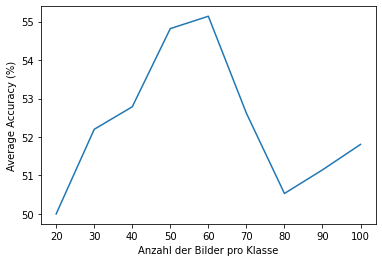

<Figure size 432x288 with 0 Axes>

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

accuracy_per_bin = []
for i in range(number_of_bins):
  if num_partitions_per_bin[i] == 0:
    accuracy_per_bin.append(np.NaN)
  else:
    accuracy_per_bin.append(summed_accuracies_of_binned_partions[i] /
                            num_partitions_per_bin[i] * 100)

plt.plot([20 + i * 10 for i in range(number_of_bins)],
          accuracy_per_bin)
plt.xlabel('Anzahl der Bilder pro Klasse')
plt.ylabel('Average Accuracy (%)')
plt.show()
plt.savefig('avg_val_acc_per_bin_size.png')

Als letztes wird die *Confusion Matrix* für das Modell mit dem größten Trainingsdatensatz erstellt.

Found 800 validated image filenames belonging to 10 classes.
Found 200 validated image filenames belonging to 10 classes.
Found 2482 validated image filenames belonging to 10 classes.
Klassifiziere die Testdaten...
249/249 [==============================] - 67s 268ms/step


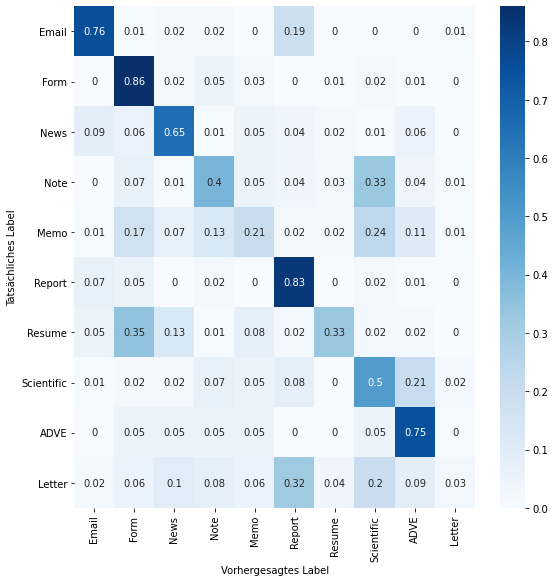

<Figure size 432x288 with 0 Axes>

In [21]:
def plot_confusion_matrix_for_max_train_imgs(model,
                                             index_of_biggest_partition: int
                                             ):

  _, _, test_generator = \
    create_data_generators(partitions[index_of_biggest_partition][0],
                           partitions[index_of_biggest_partition][1],
                           partitions[index_of_biggest_partition][2])

  test_generator.reset()

  # Klassifizierung vornehmen
  print('Klassifiziere die Testdaten...')
  y_pred = model.predict(test_generator, verbose=1)
  
  test_df = partitions[index_of_biggest_partition][2]
  y_true = test_df['Label']
  # String Bezeichner in die numerischen Label umwandeln
  y_true_numeric = [test_generator.class_indices[i] for i in y_true.to_numpy()]
  
  # Confusion Matrix berechnen und normieren
  con_mat = confusion_matrix(labels=y_true_numeric,
                             predictions=y_pred.argmax(axis=1)).numpy()

  con_mat_norm = np.around(con_mat.astype('float') / 
                           con_mat.sum(axis=1)[:, np.newaxis], decimals=2)
  con_mat_df = pd.DataFrame(con_mat_norm,
                            index = labels, 
                            columns = labels)
  figure = plt.figure(figsize=(8, 8))

  sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
  plt.tight_layout()
  plt.ylabel('Tatsächliches Label')
  plt.xlabel('Vorhergesagtes Label')
  plt.show()
  plt.savefig('confusion_matrix.png')

# Confusion Matrix plotten
plot_confusion_matrix_for_max_train_imgs(model_with_max_training,
                                         biggest_partition_index)